# **Evolutionary encryption using the *Vigenère cipher***
<h5> Created by Giulia LM </h5>

---

The cipher developed by Blaise de Vigenère during the 16th century was considered unbreakable for many years, earning it the nickname *the unbreakable cipher*. Despite its current vulnerability, this cipher had a significant impact on cryptography.
In this notebook, a genetic algorithm in Python is presented, designed to optimize the encryption key for a specific message using the Vigenère cipher.

In [ ]:
import numpy as np
import random
import string
import copy
import matplotlib.pyplot as plt

## Vigenère Cipher

This cipher works by using a keyword as the base for encryption, which is repeated to match the length of the plaintext message. Each letter of the keyword is used to determine the offset value of the corresponding letter in the plaintext.

To encrypt a message, each letter of the plaintext is shifted by the corresponding letter of the keyword. This is done using a table called a Vigenère square, a grid of alphabets in which each row represents a shift of one position from the previous row. The letter at the intersection of the keyword letter and the plaintext letter in the Vigenère square gives the encrypted letter.

<div style="text-align: center;">
  <a href="http://www.wyrmis.com/random/cipher/vigenere.html">
    <img src="http://www.wyrmis.com/png/vigsquare.png" alt="Vigenère table" title="'Vigenere Cipher System' by W Doug Bolden" style="width: 300px;"/>
  </a>
</div>


There are two formulas proposed by Vigenère for the encryption and decryption of his method. These procedures are given by:

- Cipher: <br>
$C[i] = (P[i] + K[i]) mod 26$

- Decipher: <br>
$P[i] = (C[i] - K[i]) mod 26$

Where:
- $C[i]$ is the ith character of the ciphertext.
- $P[i]$ is the ith character of the plaintext converted to its position in the alphabet (A=0, B=1, ..., Z=25).
- $K[i]$ is the ith character of the key converted to its position in the alphabet (A=0, B=1, ..., Z=25).


In [2]:
class Vigenere:
    def __init__(self, plain_text, key):
        self.plain_text = plain_text
        self.key = key
        self.ciphertext = self.encrypt()

    def encrypt(self):
        ciphertext = ''

        ascii_text = [ord(letter) for letter in self.plain_text]
        ascii_key = [ord(letter) for letter in self.key]

        for i in range(len(ascii_text)):
          value = (ascii_text[i]+ ascii_key[i % len(ascii_key)]) % 26
          ciphertext += chr(value + 65)
        return ciphertext

    def dencrypt(self):
        plain_text = ''

        ascii_ciphertext = [ord(letter) for letter in self.ciphertext]
        ascii_key = [ord(letter) for letter in self.key]

        for i in range(len(ascii_ciphertext)):
          value = (ascii_ciphertext[i] - ascii_key[i % len(ascii_key)]) % 26
          plain_text += chr(value + 65)

        self.plain_text = plain_text

## Genetic Algorithm

A genetic algorithm is a search and optimization method inspired by the process of natural selection, it uses operators such as selection, crossover, and mutation to evolve solutions to a problem over several generations. THese are the choosen fucntions for each part of the algotithm:

- Tournament Selection: Subgroups of individuals are chosen from the population, and members of each subgroup compete with each other. Only one individual from each subgroup is chosen for reproduction.
- Fitness Function: Maximum incidence count, seeking to find individuals with the lowest fitness.
- Single Point Crossover: A swap point is established at a random location in the genome of the two individuals, and one of the individuals contributes all of its previous code to that location, while the other individual contributes all of its code from that location onward to produce offspring.
- Swap Mutations: Two letters are exchanged at randomly chosen locations in a single individual.

### Operation for the number of occurrences of a letter according to n displacements:

In [ ]:
def displacements(text, n):
    moved_texts = []
    len_text = len(text)

    for i in range(n):
        moved_text = []
        for j in range(len_text):
            moved_text.append(text[(i + j) % len_text])
        moved_texts.append(moved_text)

    moved_texts = np.array(moved_texts)
    return moved_texts

def matches(text, n):
    displacement = displacements(text, n)
    match = np.zeros(len(text), dtype=int)

    for i in range(len(text)):
        column = displacement[:, i]
        cunique, counts = np.unique(column, return_counts=True)
        match[i] = np.max(counts)
    return max(match)

In [ ]:
class GeneticAlgorithm:
    def __init__(self, text, population_size, n_generations):
        self.population_size = population_size
        self.n_generations = n_generations
        self.population = []
        self.text = text

    def initialize_population(self):
        for i in range(self.population_size):
            rndlen = random.randint(2, len(self.text)//3)

            key = ''.join([random.choice(string.ascii_uppercase) for _ in range(rndlen)])
            keyndividual = Vigenere(self.text, key)
            self.population.append(keyndividual)

    def singlepoint_crossover(self, parent1, parent2):
        minparent = min(len(parent1.key), len(parent2.key))
        point = random.randint(0, minparent )

        key1 = parent1.key[:point] + parent2.key[point:]
        key2 = parent2.key[:point] + parent1.key[point:]

        child1 = Vigenere(self.text, key1)
        child2 = Vigenere(self.text, key2)

        return child1, child2

    def tournament_selection(self, fitness_values):
        tournament = random.sample(range(len(self.population)), k=10)
        tournament_fitness_values = [fitness_values[i] for i in tournament]
        winner_local_index = np.argmin(tournament_fitness_values)

        winner_index = tournament[winner_local_index]
        return winner_index

    def swap_mutation(self, individual):
        mutated = copy.deepcopy(individual)
        index1 = random.randint(0,len(mutated.key) - 1)
        index2 = random.randint(0,len(mutated.key) - 1)

        mutated.key = list(mutated.key)
        mutated.key[index2], mutated.key[index1] = mutated.key[index1], mutated.key[index2]
        mutated.key = ''.join(mutated.key)

        return mutated

    def run(self):
        self.initialize_population()
        n_displacements = len(self.text) // 3
        best_solution_value = float('inf')
        best_solution = None
        fitness_evolution = []
        average_fitness_evolution = []
        key_length_evolution = []

        for i in range(self.n_generations):
            print(f'Current generation: {i}')
            fitness_values = [matches(individual.ciphertext, n_displacements) for individual in self.population]
            current_best_index = np.argmin(fitness_values)
            current_best_fitness = fitness_values[current_best_index]
            current_best_solution = self.population[current_best_index]

            if current_best_fitness < best_solution_value:
                best_solution_value = current_best_fitness
                best_solution = current_best_solution

            new_population = []
            for _ in range(self.population_size // 2):
                parent1 = self.population[self.tournament_selection(fitness_values)]
                parent2 = self.population[self.tournament_selection(fitness_values)]
                child1, child2 = self.singlepoint_crossover(parent1, parent2)
                child1 = self.swap_mutation(child1)
                child2 = self.swap_mutation(child2)
                new_population.extend([child1, child2])

            self.population = new_population

            # compute mean fitness
            average_fitness = np.mean(fitness_values)
            fitness_evolution.append(current_best_fitness)
            average_fitness_evolution.append(average_fitness)
            key_length_evolution.append(np.mean([len(individual.key) for individual in self.population]))

        print('------------------------')
        print("Best key:", best_solution.key)
        print("Cipher text by the key:", best_solution.ciphertext)
        print("Best key fitness:", best_solution_value)
        print("Best key length:", len(best_solution.key))

        return fitness_evolution, average_fitness_evolution, key_length_evolution

## Testing and results
Due to hardware limitations, the population size chosen for the test was set to 100 bits and only 10 generations for the genetic algorithm. The selected text to encrypt was the first three pages of the "Moby Dick" novel, preprocessed specifically to be compatible with the displacement fitness function. 

In [ ]:
from utils import process, visualize

text = process("mobydick.txt")
population_size = 100
n_generations = 10


ga = GeneticAlgorithm(text, population_size, n_generations)
ga.initialize_population()
fitness_evolution, average_fitness_evolution, key_length_evolution = ga.run()

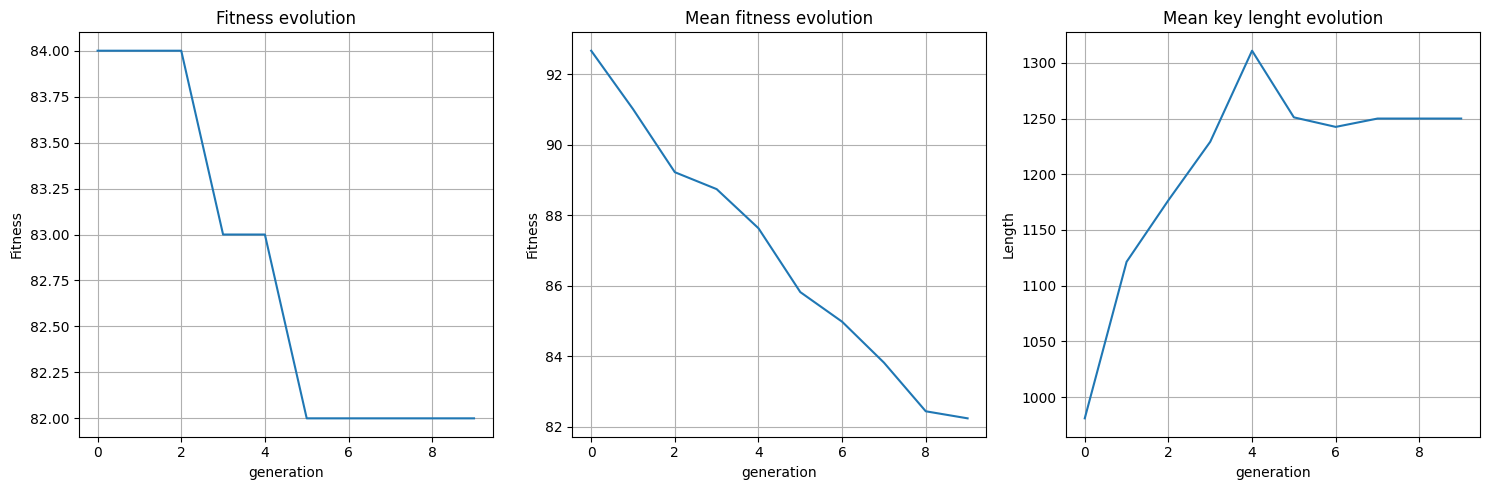

In [16]:
visualize(n_generations, fitness_evolution, average_fitness_evolution, key_length_evolution)

Since this is a minimization function, it was expected that individuals with lower fitness would be better than others. As can be seen on the "Best fitness evolution" and the "Mean fitness evolution", the average fitness decreased with each generation, indicating significant progress toward the initial goal.
The key length, on the other hand, increased with each generation, indicating that the longer the key, the better the key for encrypting the given text.

If you're interested in reading a *spanish* and profound explanation of this project, i invite you to read the pdf written about it: https://drive.google.com/file/d/1_nfnA2hL5vhaxsXNbgnDull1LhcRaktZ/view?usp=sharing